## are the coexpression block boundries the same as TADs?

we define the start and end of a cluster as the start and end of its first and last gene. 


then we look to see if clusters overlap multiple TADs, or are contained within a single TAD.

In [129]:
import pandas as pd
import pyranges as pr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import os
import scipy as sp


In [130]:
# get output directories from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/pcqtl_proteincoding.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

tissue_id_path = config['tissue_id_path']
clusters_dir = config['clusters_dir']


# load in the tissue ids 
tissue_df = pd.read_csv(f"{prefix}/{tissue_id_path}", header=0)
tissue_ids = list(tissue_df['Tissue'])

# select just 1 tissue id to do for now 
tissue_id = 'Cells_Cultured_fibroblasts' # because only one cell type

### load in data

In [189]:
# download the tad boundries
# data from http://dna.cs.miami.edu/TADKB/search.php
tad_path = '/home/klawren/oak/coexp_eqtl/data/TAD_annotations/TADs_hg38/converted_HiC_GM12878_DI_10kb.txt'


#tad_path = '/home/klawren/oak/coexp_eqtl/data/TAD_annotations/TADs/HiC_CH12-LX_DI_10kb.txt'

tad_df = pd.read_csv(tad_path, header=None, sep='\t', names=['Chromosome', 'start','end'])
tad_df.head()

,Chromosome,start,end
0,chr1,784620,1314620
1,chr1,1374620,1748561
2,chr1,1748561,1918561
3,chr1,1918561,2058561
4,chr1,2188561,2388561


In [132]:
# annotate clusters with the start and end of the first and last gene
# download the gene list 
gtf_path = '/home/klawren/oak/pcqtls/data/references/gencode.v26.GRCh38.genes.gtf'

full_g = pr.read_gtf(gtf_path)
transcript_df = full_g[full_g.Feature == 'transcript'].df
transcript_df.set_index('transcript_id', inplace=True)
transcript_df.head()

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,gene_name,transcript_type,transcript_name,level,havana_gene,exon_id,exon_number,tag
transcript_id,,,,,,,,,,,,,,,,,,
ENSG00000223972.5,chr1,HAVANA,transcript,11868,14403,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,transcribed_unprocessed_pseudogene,DDX11L1,2,OTTHUMG00000000961.2,NaN,NaN,NaN
ENSG00000243485.5,chr1,HAVANA,transcript,29570,31109,.,+,.,ENSG00000243485.5,lincRNA,MIR1302-2HG,lincRNA,MIR1302-2HG,2,OTTHUMG00000000959.2,NaN,NaN,ncRNA_host
ENSG00000268020.3,chr1,HAVANA,transcript,52472,53312,.,+,.,ENSG00000268020.3,unprocessed_pseudogene,OR4G4P,unprocessed_pseudogene,OR4G4P,2,OTTHUMG00000185779.1,NaN,NaN,NaN
ENSG00000240361.1,chr1,HAVANA,transcript,62947,63887,.,+,.,ENSG00000240361.1,unprocessed_pseudogene,OR4G11P,unprocessed_pseudogene,OR4G11P,2,OTTHUMG00000001095.2,NaN,NaN,NaN
ENSG00000186092.4,chr1,HAVANA,transcript,69090,70008,.,+,.,ENSG00000186092.4,protein_coding,OR4F5,protein_coding,OR4F5,2,OTTHUMG00000001094.2,NaN,NaN,NaN


### start and end of clusters

In [133]:
def get_start(row):
    row_df = transcript_df.loc[row.Transcripts.split(',')]
    return row_df.Start.min()

def get_end(row):
    row_df = transcript_df.loc[row.Transcripts.split(',')]
    return row_df.End.max()

In [134]:
# df of clusters in all tissue types
cluster_dfs=[]
for tissue_id in tissue_ids:
    cluster_dfs.append(pd.read_csv(f'{prefix}/{clusters_dir}/{tissue_id}_clusters_all_chr.csv', index_col=0))
clusters = pd.concat(cluster_dfs)

In [135]:
clusters['start'] = clusters.apply(get_start, axis=1)
clusters['end'] = clusters.apply(get_end, axis=1)
clusters['Chromosome']  = 'chr' + clusters['Chromosome'].astype(str)
clusters['log_size'] = np.log10(clusters['end'] - clusters['start'])
clusters['cluster_size'] = clusters['end'] - clusters['start']
clusters['inter'] = pd.arrays.IntervalArray.from_arrays(clusters['start'], clusters['end'])

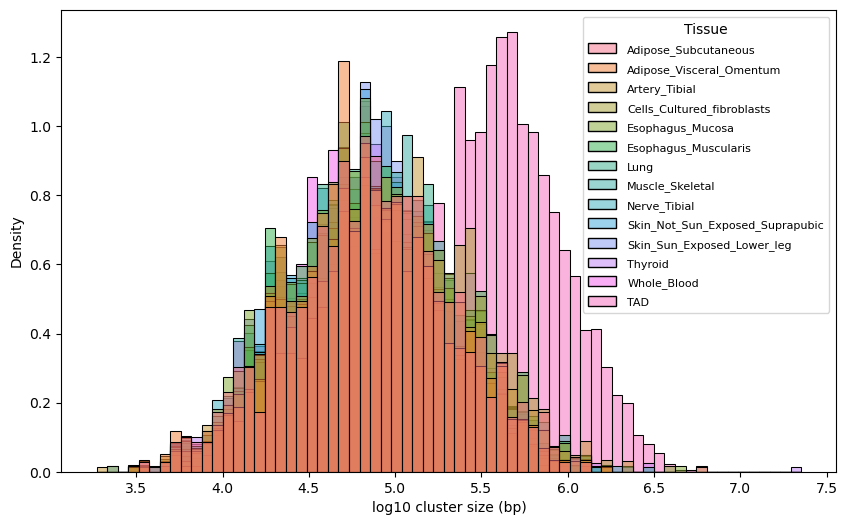

In [197]:
tad_df['log_size'] = np.log10(tad_df['end'] - tad_df['start'])
tad_df['Tissue'] = 'TAD'

fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(pd.concat([clusters[['log_size', 'Tissue']], tad_df[['log_size', 'Tissue']]]), x='log_size', stat='density', hue='Tissue', common_norm=False, ax=ax)

ax.set_xlabel('log10 cluster size (bp)')
plt.setp(ax.get_legend().get_texts(), fontsize='8') # for legend text
plt.show()

<AxesSubplot: xlabel='N_genes', ylabel='log_size'>

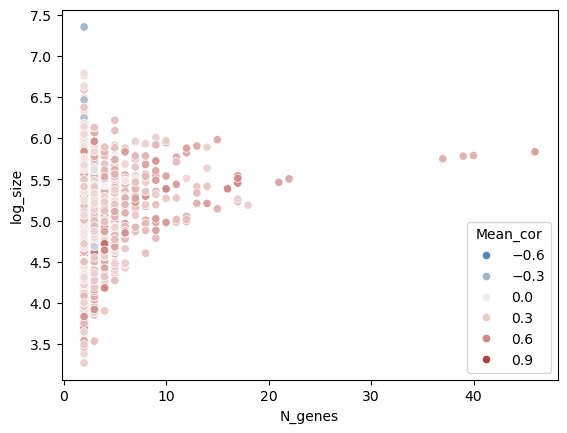

In [198]:
# are the larger clusters the ones with more genes? not really

sns.scatterplot(data=clusters, x='N_genes', y='log_size', hue='Mean_cor', palette='vlag')

### TAD overlap

In [199]:
# check how many tads each cluster overlaps
clusters['inter'] = pd.arrays.IntervalArray.from_arrays(clusters['start'], clusters['end'])
tad_df['inter'] = pd.arrays.IntervalArray.from_arrays(tad_df['start'], tad_df['end'])

def count_tad_overlap(row):
    tad_chr = tad_df[tad_df['Chromosome']==row.Chromosome]
    chr_tad_intervals = pd.arrays.IntervalArray.from_arrays(tad_chr['start'], tad_chr['end'])
    return sum(chr_tad_intervals.overlaps(row['inter']))

<AxesSubplot: xlabel='num_tads', ylabel='Density'>

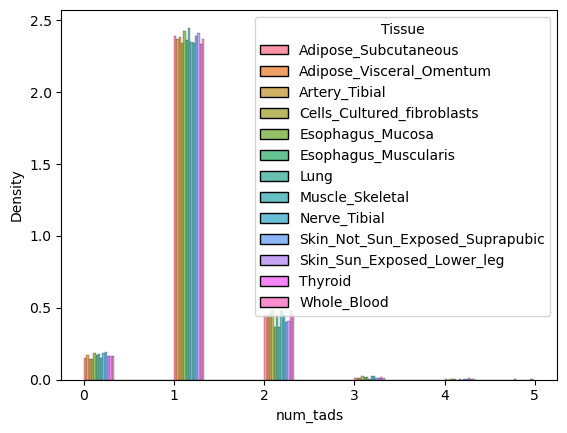

In [200]:
clusters['num_tads'] = clusters.apply(count_tad_overlap, axis=1)
sns.histplot(clusters, x='num_tads', hue='Tissue',stat='density', common_norm=False, multiple='dodge')

<AxesSubplot: xlabel='num_tads', ylabel='count'>

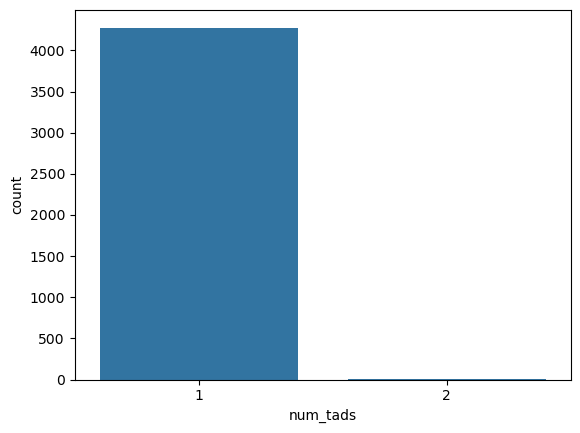

In [201]:
# sanity check to see if TADs are non-overlapping 
# this should all be 1
tad_df['num_tads'] = tad_df.apply(count_tad_overlap, axis=1)
sns.countplot(tad_df, x='num_tads')

## Null with gene number

It does look like most clusters are in only 1 TAD. But this could just be due to the fact that clusters are smaller than TADs! I need a null group. This could be 

* groups of similarly sized intervals to compare to. 
* groups of similar numbers of genes (need to check if these result in the same sized clusters)

In [202]:
# get random stretches of genes that are the same number, then check if they are the same distance distribution (roughly)
transcript_df = transcript_df[transcript_df.Chromosome.isin(clusters.Chromosome.unique())]
# sort genes and add an increasing index
transcript_df.sort_values(['Chromosome', 'Start'], inplace=True)
transcript_df.reset_index(inplace=True)

In [203]:
def get_null_num_genes(num=None, clusters=clusters):
    # chose how many genes to get 
    if num==None:
        num=len(clusters)
    # chose genes to be the start of the clusters
    transcript_df.sample(num, replace=True)
    # then extend by the number of genes in the cluster
    null_inter=[]
    for n in clusters.N_genes:
        diff_chr=True
        while diff_chr:
            sead_idx = np.random.randint(len(transcript_df))
            null_genes = transcript_df.iloc[sead_idx:sead_idx+n]
            diff_chr = (null_genes.iloc[0].Chromosome != null_genes.iloc[-1].Chromosome)
        null_inter.append([n, null_genes.transcript_id.values, null_genes.Chromosome.iloc[0], null_genes.Start.min(), null_genes.End.max()])
        
    null_df = pd.DataFrame(null_inter, columns=['N_genes', 'Transcripts', 'Chromosome', 'start', 'end'])
    null_df['inter'] = pd.arrays.IntervalArray.from_arrays(null_df['start'], null_df['end'])
    null_df['num_tads'] = null_df.apply(count_tad_overlap, axis=1)
    return null_df


In [204]:
# generate a whole null distribution
null_df=get_null_num_genes(num=20000, clusters=clusters)
null_df['Tissue'] = 'null_num_genes'



In [205]:
# make into one df
plot_df = pd.concat([clusters[['num_tads', 'Tissue']], null_df[['num_tads', 'Tissue']]], keys=['clusters', 'null_genes'])
plot_df.reset_index(names=['data_type', 'idx'], inplace=True)

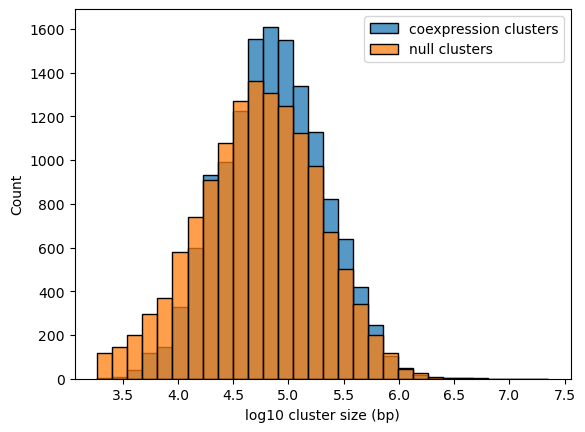

In [206]:
# check to see if inter-cluster distances are the same (as expected)
_, bins = np.histogram(np.log10(clusters['end'] - clusters['start']), bins=30)
sns.histplot(np.log10(clusters['cluster_size']), label='coexpression clusters', bins=bins)
sns.histplot(np.log10(null_df['end'] - null_df['start']), label='null clusters', bins=bins)

plt.xlabel('log10 cluster size (bp)')
plt.legend()

they are roughly the same size, perhaps the null is slightly smaller. But that will make it a conservative null in terms of TADs overlapped

Text(0.5, 1.0, 'Counts of TADs overlapped for coexpression clusters')

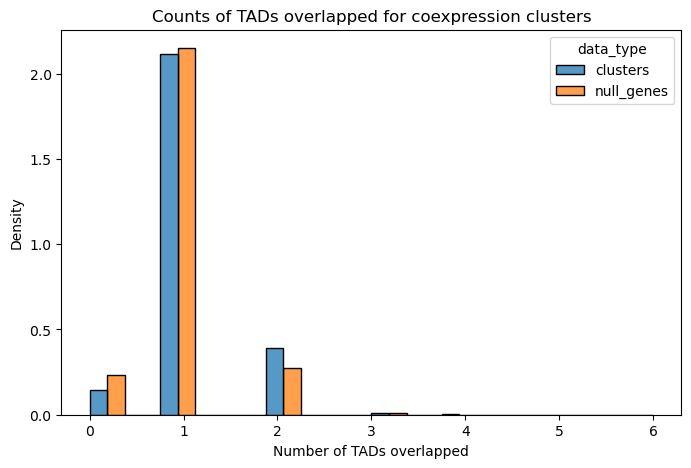

In [207]:
fig, ax = plt.subplots(figsize=(8,5))

sns.histplot(plot_df, x='num_tads', hue='data_type', stat='density', common_norm=False, multiple='dodge', ax=ax)
plt.xlabel('Number of TADs overlapped')
plt.title('Counts of TADs overlapped for coexpression clusters')

In [208]:
# load in the chr lengths
genome_path = '/home/klawren/oak/coexp_eqtl/data/hg38.bed'
genome_df = pd.read_csv(genome_path, header=None, names=['Chromosome', 'start','end'], sep=' ')
genome_df.set_index('Chromosome', inplace=True)
genome_df.head()

,start,end
Chromosome,,
chr1,0,248956422
chr2,0,242193529
chr3,0,198295559
chr4,0,190214555
chr5,0,181538259


we could also do the null distribution based only on the length of the intervals

In [209]:
def get_null_dist(num=None, clusters=clusters):
    # chose how many genes to get 
    if num==None:
        num=len(clusters)
    null_inter=[]
    # go through each chromosome and get segments of length equal to the clusters there
    for chrom, sub_cluster in clusters.sample(num, replace=True).groupby('Chromosome'):
        idxs=[]
        for idx, row in sub_cluster.iterrows():
            idxs.append(np.random.randint(genome_df.loc[chrom]['end'] - row.cluster_size))

        null_inter.append(pd.DataFrame({'Chromosome':chrom, 'N_genes':len(sub_cluster), 'start':idxs, 'end':idxs + sub_cluster.cluster_size}))
    # make a df an annotate
    null_df = pd.concat(null_inter)
    null_df['inter'] = pd.arrays.IntervalArray.from_arrays(null_df['start'], null_df['end'])
    null_df['num_tads'] = null_df.apply(count_tad_overlap, axis=1)
    return null_df


In [210]:
null_dist_df = get_null_dist(num=20000, clusters=clusters)
null_dist_df['Tissue'] = 'null_interval_length'


# make into one df
plot_df = pd.concat([clusters[['num_tads', 'Tissue']], null_df[['num_tads', 'Tissue']], null_dist_df[['num_tads', 'Tissue']]], keys=['clusters', 'null_genes', 'null_length'])
plot_df.reset_index(names=['data_type', 'idx'], inplace=True)


Text(0.5, 1.0, 'Counts of TADs overlapped for coexpression clusters')

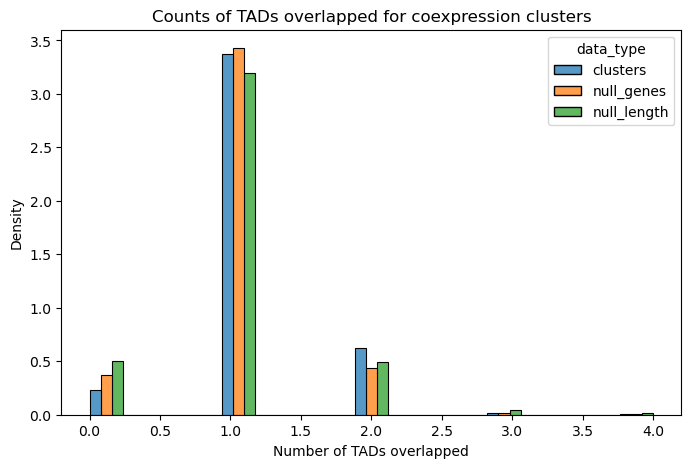

In [211]:
fig, ax = plt.subplots(figsize=(8,5))

plot_df['num_tads_clip'] = plot_df['num_tads'].clip(0,4)

sns.histplot(plot_df, x='num_tads_clip', hue='data_type', stat='density', common_norm=False, multiple='dodge', ax=ax)
plt.xlabel('Number of TADs overlapped')
plt.title('Counts of TADs overlapped for coexpression clusters')

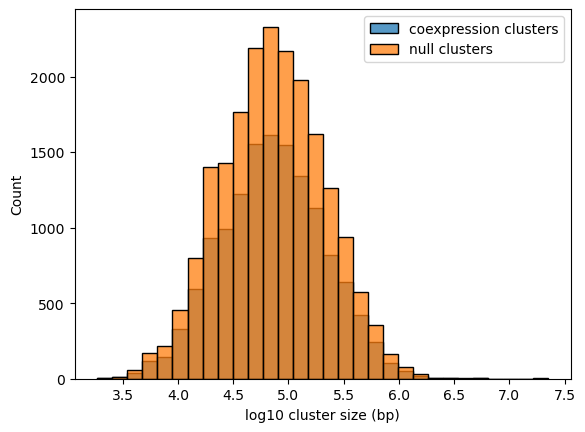

In [212]:
# check to see if inter-cluster distances are the same (as expected)
_, bins = np.histogram(np.log10(clusters['end'] - clusters['start']), bins=30)
sns.histplot(np.log10(clusters['cluster_size']), label='coexpression clusters', bins=bins)
sns.histplot(np.log10(null_dist_df['end'] - null_dist_df['start']), label='null clusters', bins=bins)

plt.xlabel('log10 cluster size (bp)')
plt.legend()

## postive vs negative corr clusters

In [226]:
# what if we restict just to clusters with positive corrleation?

partial_cluster = clusters[~clusters['Mean_neg_cor'].isna()]


# make into one df
plot_df = pd.concat([clusters[['num_tads', 'Tissue']],partial_cluster[['num_tads', 'Tissue']], null_df[['num_tads', 'Tissue']], null_dist_df[['num_tads', 'Tissue']]], keys=['clusters', 'neg_corr_cluster', 'null_genes', 'null_length'])
plot_df.reset_index(names=['data_type', 'idx'], inplace=True)


Text(0.5, 1.0, 'Counts of TADs overlapped for coexpression clusters')

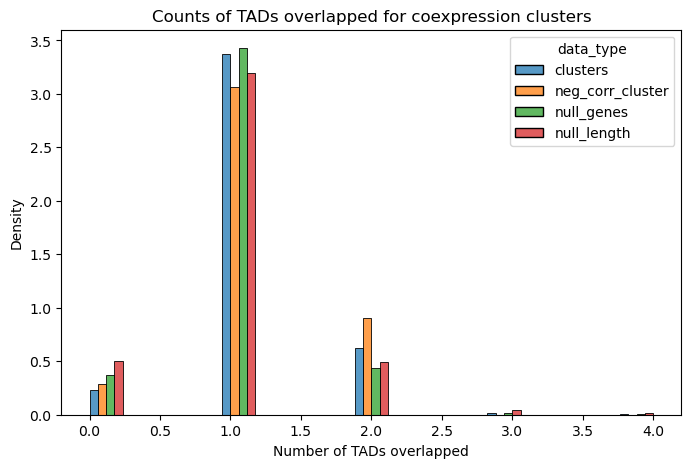

In [227]:
fig, ax = plt.subplots(figsize=(8,5))

plot_df['num_tads_clip'] = plot_df['num_tads'].clip(0,4)

sns.histplot(plot_df, x='num_tads_clip', hue='data_type', stat='density', common_norm=False, multiple='dodge', ax=ax)
plt.xlabel('Number of TADs overlapped')
plt.title('Counts of TADs overlapped for coexpression clusters')

the negative correlations do seem to overlap 2+ tads more often. Try comparing these to the high positive corrs

<AxesSubplot: xlabel='Mean_pos_cor', ylabel='Count'>

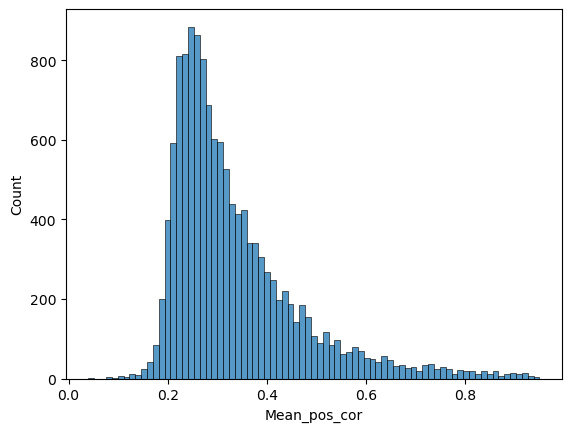

In [228]:
sns.histplot(clusters['Mean_pos_cor'])

Text(0.5, 1.0, 'Counts of TADs overlapped for coexpression clusters')

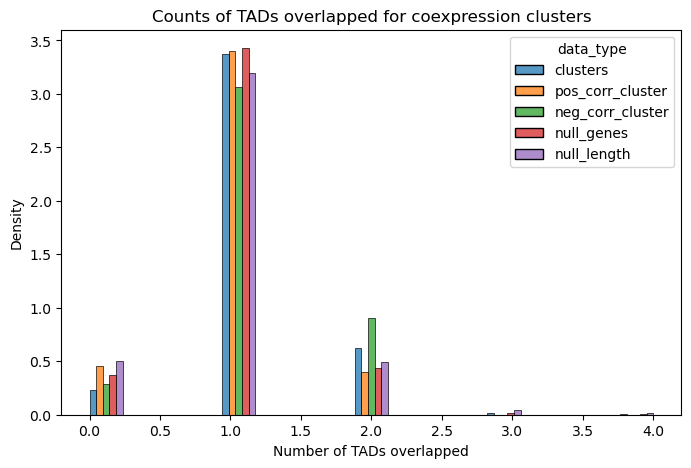

In [229]:
# what if we restict just to clusters with positive corrleation?

neg_cluster = clusters[~clusters['Mean_neg_cor'].isna()]

# pick .6 as a highish positive corr, and requrie the cluster has no negative corr
pos_cluster = clusters[(clusters['Mean_neg_cor'].isna()) & (clusters['Mean_pos_cor']>.7)]


# make into one df
plot_df = pd.concat([clusters[['num_tads', 'Tissue']], 
                     pos_cluster[['num_tads', 'Tissue']], 
                     neg_cluster[['num_tads', 'Tissue']], 
                     null_df[['num_tads', 'Tissue']], 
                     null_dist_df[['num_tads', 'Tissue']]], 
                     keys=['clusters', 'pos_corr_cluster', 'neg_corr_cluster', 'null_genes', 'null_length'])
plot_df.reset_index(names=['data_type', 'idx'], inplace=True)


fig, ax = plt.subplots(figsize=(8,5))

plot_df['num_tads_clip'] = plot_df['num_tads'].clip(0,4)

sns.histplot(plot_df, x='num_tads_clip', hue='data_type', stat='density', common_norm=False, multiple='dodge', ax=ax)
plt.xlabel('Number of TADs overlapped')
plt.title('Counts of TADs overlapped for coexpression clusters')


I do see a differnece, with pos corr clusters more likely to be in one TAD, and neg corr clusters more likely to cross tads. But could this be due to different sizes of the pos and neg clusters?

<AxesSubplot: xlabel='log_size', ylabel='Count'>

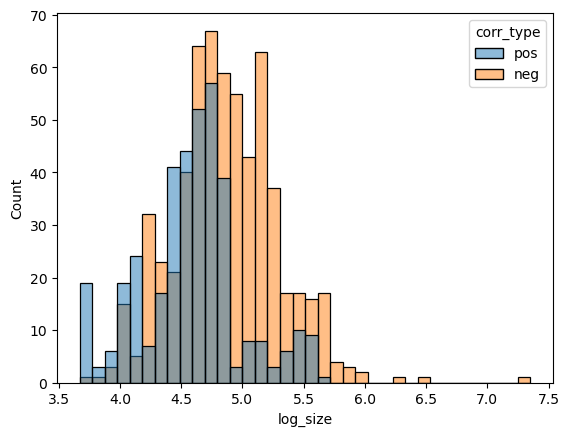

In [230]:
# are the length distributions differnt?

pos_neg_df = pd.DataFrame(pd.concat([pos_cluster['log_size'], neg_cluster['log_size']], keys=['pos', 'neg'])).reset_index(names=['corr_type', 'idx'])
sns.histplot(pos_neg_df, x= 'log_size', hue='corr_type')

The lnegth distributions are different, so I will resample them to match 

In [231]:
# code from ben
# target has to be smaller or the two, n is length of target

def resample_dist(target, candidate_pool, n, seed=126124):   
    """Match a target distribution via weighted sampling from a candidate pool
    Args:
        target, candidate_pool: 1D numpy arrays with values ranging from 0 to 1
        n: integer number of indices to return
    Return:
        n indices to elements candidate_pool to use for the sample
    """
    rng = np.random.default_rng(seed)
    target_prob = sp.stats.gaussian_kde(target)
    candidate_prob = sp.stats.gaussian_kde(candidate_pool)

    bins = np.arange(0, 1, 0.0001)
    sampling_weight = target_prob(bins) / candidate_prob(bins)
    pool_bins = np.searchsorted(bins, candidate_pool) - 1
    pool_probability = sampling_weight[pool_bins]/sampling_weight[pool_bins].sum()

    return rng.choice(candidate_pool.size, size=n, replace=True, p=pool_probability)

In [232]:
candidate_pool = (pos_cluster['log_size']/clusters['log_size'].max())
target = (neg_cluster['log_size']/clusters['log_size'].max())

n=200

resamp_idxs_pos = resample_dist(target, candidate_pool, n)
resamp_idxs_neg = resample_dist(target, target, n)

<AxesSubplot: xlabel='log_size', ylabel='Count'>

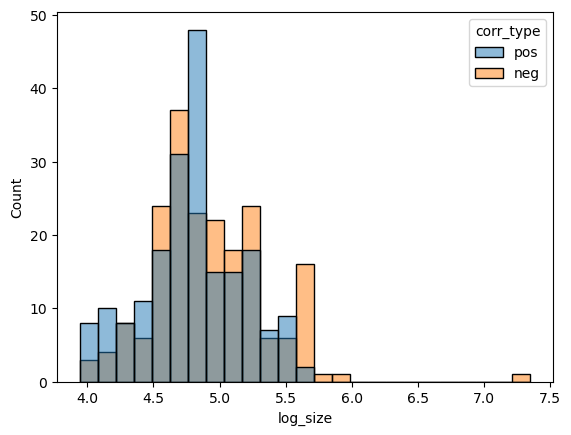

In [233]:
pos_neg_df = pd.DataFrame(pd.concat([pos_cluster.iloc[resamp_idxs_pos], neg_cluster.iloc[resamp_idxs_neg]], keys=['pos', 'neg'])).reset_index(names=['corr_type', 'idx'])
sns.histplot(pos_neg_df, x= 'log_size', hue='corr_type')

That's a better match. Lets look at TAD overlap again

Text(0.5, 1.0, 'Counts of TADs overlapped for coexpression clusters (resampled to match distance)')

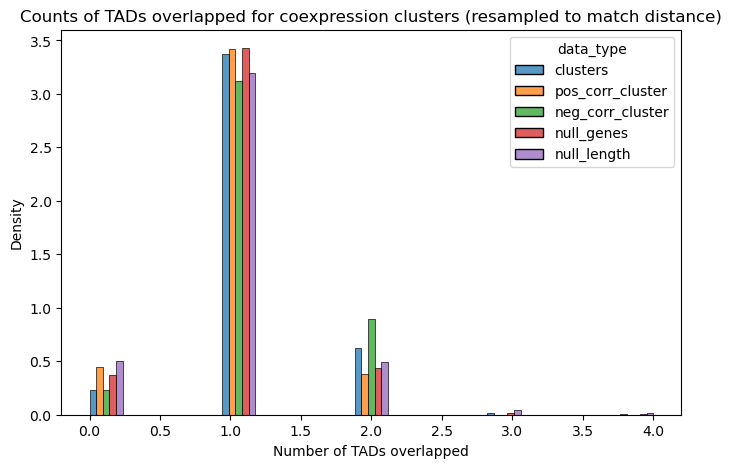

In [234]:
# what if we restict just to clusters with positive corrleation?

# make into one df
plot_df = pd.concat([clusters[['num_tads', 'Tissue']], 
                     pos_cluster.iloc[resamp_idxs_pos][['num_tads', 'Tissue']], 
                     neg_cluster.iloc[resamp_idxs_neg][['num_tads', 'Tissue']], 
                     null_df[['num_tads', 'Tissue']], 
                     null_dist_df[['num_tads', 'Tissue']]], 
                     keys=['clusters', 'pos_corr_cluster', 'neg_corr_cluster', 'null_genes', 'null_length'])
plot_df.reset_index(names=['data_type', 'idx'], inplace=True)


fig, ax = plt.subplots(figsize=(8,5))

plot_df['num_tads_clip'] = plot_df['num_tads'].clip(0,4)

sns.histplot(plot_df, x='num_tads_clip', hue='data_type', stat='density', common_norm=False, multiple='dodge', ax=ax)
plt.xlabel('Number of TADs overlapped')
plt.title('Counts of TADs overlapped for coexpression clusters (resampled to match distance)')


Text(0.5, 1.0, 'Counts of TADs overlapped for coexpression clusters')

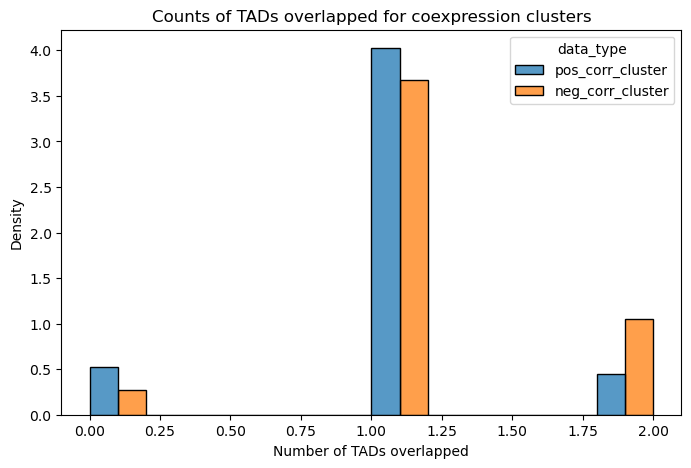

In [235]:

# make into one df
plot_df = pd.concat([pos_cluster.iloc[resamp_idxs_pos][['num_tads', 'Tissue']], 
                     neg_cluster.iloc[resamp_idxs_neg][['num_tads', 'Tissue']]], 
                     keys=['pos_corr_cluster', 'neg_corr_cluster'])
plot_df.reset_index(names=['data_type', 'idx'], inplace=True)


fig, ax = plt.subplots(figsize=(8,5))

sns.histplot(plot_df, x='num_tads', hue='data_type', stat='density', common_norm=False, multiple='dodge', ax=ax)
plt.xlabel('Number of TADs overlapped')
plt.title('Counts of TADs overlapped for coexpression clusters')


but is this signifigant? one way to get error bars would be to resample a few times, then use the std of that resampling

In [236]:
# what if we restict just to clusters with positive corrleation?
pos_counts=[]
neg_counts=[]
for i in tqdm(range(100)):
    n=250
    resamp_idxs_pos = resample_dist(target, candidate_pool, n, seed=i)
    resamp_idxs_neg = resample_dist(target, target, n, seed=i)
    pos_counts.append(pos_cluster.iloc[resamp_idxs_pos]['num_tads'].value_counts())
    neg_counts.append(neg_cluster.iloc[resamp_idxs_neg]['num_tads'].value_counts())


100%|███████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.38it/s]


Text(0, 0.5, 'Fraction clusters')

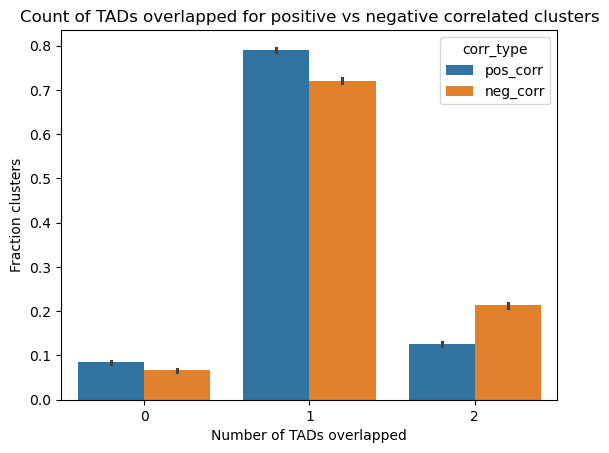

In [238]:
# normalize (since the total count vlaues are meaningless)
pos_counts_normed = [counts/np.sum(counts) for counts in pos_counts]
neg_counts_normed = [counts/np.sum(counts) for counts in neg_counts]

# combine into one df
plot_df = pd.concat([pd.concat(pos_counts_normed), pd.concat(neg_counts_normed)], keys=['pos_corr', 'neg_corr']).reset_index()
plot_df.rename(columns={'level_0':'corr_type'}, inplace=True)

# plot
sns.barplot(plot_df, hue='corr_type', y='count', x='num_tads')
plt.title('Count of TADs overlapped for positive vs negative correlated clusters')

plt.xlabel('Number of TADs overlapped')
plt.ylabel('Fraction clusters')


I can create bins of correlation to avoid having to pick an aribraty cutoff

In [239]:
clusters['corr_bin'] = np.where(~clusters['Mean_neg_cor'].isna(), 'neg', pd.cut(clusters['Mean_pos_cor'], [0, .25, .5, .75, 1]))
clusters['corr_bin'] = clusters['corr_bin'].astype(str)

Text(0.5, 1.0, 'Counts of TADs overlapped for coexpression clusters')

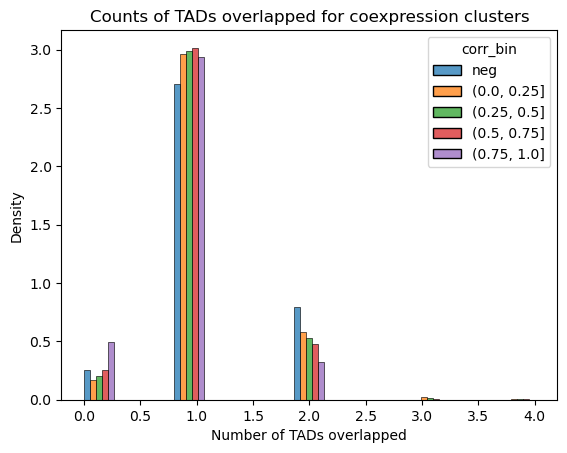

In [240]:
clusters['num_tads_clip'] = clusters['num_tads'].clip(0,4)

corr_bin_order = ['neg', '(0.0, 0.25]', '(0.25, 0.5]','(0.5, 0.75]', '(0.75, 1.0]']

sns.histplot(clusters, x='num_tads_clip', hue='corr_bin', stat='density', common_norm=False, multiple='dodge', hue_order=corr_bin_order)
plt.xlabel('Number of TADs overlapped')
plt.title('Counts of TADs overlapped for coexpression clusters')

In [257]:
# plot this as a ratio

# error bars can be from poission counting noise propegation


def calculate_ratio_error(A, B):
    # Calculate errors based on Poisson statistics
    error_A = np.sqrt(A)
    error_B = np.sqrt(B)
    # Calculate ratio
    try:
        R = A / B
    except ZeroDivisionError:
        return np.nan, np.nan
    # Propagate errors to the ratio
    error_R = R * np.sqrt((error_A / A)**2 + (error_B / B)**2)

    return R, error_R


tads_overlap_count = clusters[clusters['num_tads']>1].groupby('corr_bin')['num_tads'].count()
tads_single_count = clusters[clusters['num_tads']==1].groupby('corr_bin')['num_tads'].count()

ratios, ratio_errors = calculate_ratio_error(tads_single_count, tads_overlap_count)

Text(0, 0.5, 'clusters in 1 TAD/clusters in multiple TADs')

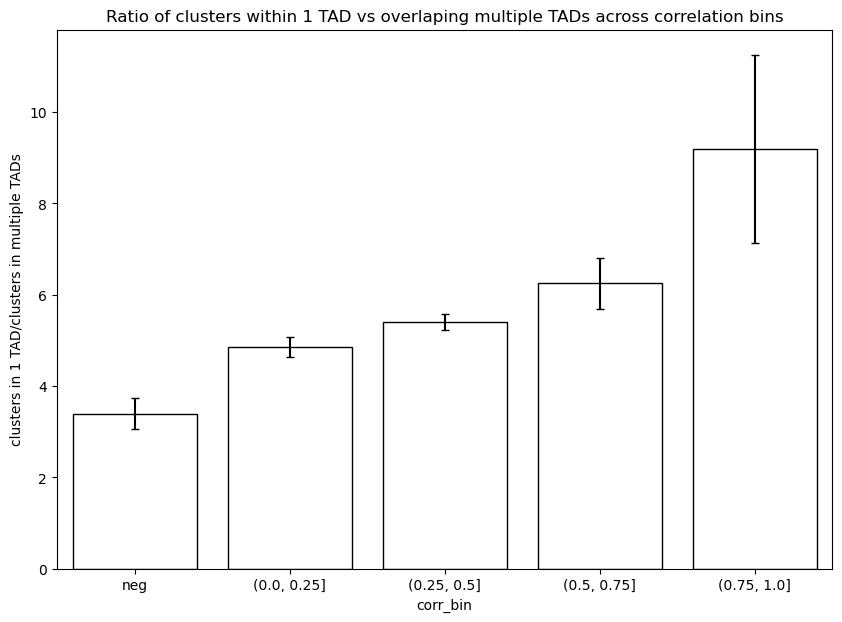

In [275]:
fig, ax = plt.subplots(figsize=(10,7))

ax.errorbar(x=corr_bin_order, y=ratios.loc[corr_bin_order], yerr=ratio_errors.loc[corr_bin_order], fmt=' ', color='k', capsize=3)

sns.barplot(ratios, order=corr_bin_order, edgecolor='k', facecolor='white')
plt.title('Ratio of clusters within 1 TAD vs overlaping multiple TADs across correlation bins')
plt.ylabel('clusters in 1 TAD/clusters in multiple TADs')

In [242]:
# what's with the spike at 3 for high corr? nope, its a bunch of the same cluster. use a grouped df instead
clusters[(clusters['corr_bin']=='(0.75, 1.0]') & (clusters['num_tads']>2)]

,N_genes,Transcripts,Genes,Perc_cor,Mean_cor,Mean_pos_cor,Mean_neg_cor,Chromosome,Tissue,start,end,log_size,cluster_size,inter,num_tads,corr_bin,num_tads_clip


## group clusters over tissues

In [247]:
# clusters need to be comibined across tissues
clusters_grouped = clusters.groupby('Transcripts').agg({
    'Mean_cor': 'mean',
    'Mean_pos_cor': 'mean',
    'Mean_neg_cor': 'mean',
    'num_tads': 'first',
    'inter':'first',
    'end':'first',
    'start':'first',
    'N_genes' :'first',
    'cluster_size': 'first',
    'Chromosome': 'first',
    'Tissue': list})

clusters_grouped['corr_bin'] = np.where(~clusters_grouped['Mean_neg_cor'].isna(), 'neg', pd.cut(clusters_grouped['Mean_pos_cor'], [0, .25, .5, .75, 1]))

In [244]:
# generate a whole null distribution
null_df=get_null_num_genes(num=20000, clusters=clusters_grouped)
null_df['Tissue'] = 'null_num_genes'

null_dist_df = get_null_dist(num=20000, clusters=clusters_grouped)
null_dist_df['Tissue'] = 'null_interval_length'


# make into one df
plot_df = pd.concat([clusters_grouped[['num_tads', 'Tissue']], null_df[['num_tads', 'Tissue']], null_dist_df[['num_tads', 'Tissue']]], keys=['clusters', 'null_genes', 'null_length'])
plot_df.reset_index(names=['data_type', 'idx'], inplace=True)


Text(0.5, 1.0, 'Counts of TADs overlapped for coexpression clusters')

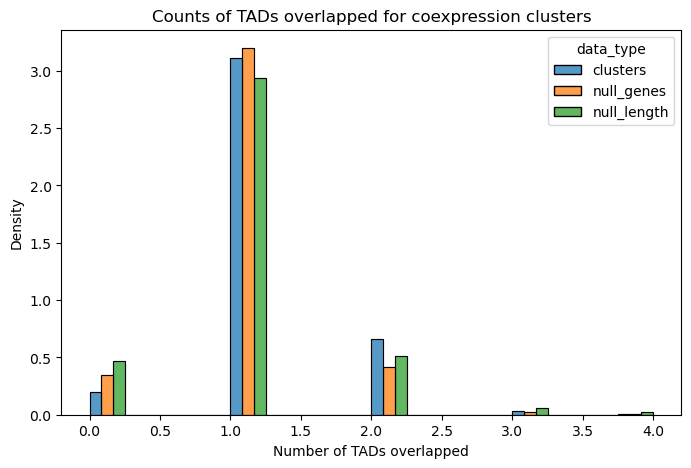

In [245]:
fig, ax = plt.subplots(figsize=(8,5))

plot_df['num_tads_clip'] = plot_df['num_tads'].clip(0,4)

sns.histplot(plot_df, x='num_tads_clip', hue='data_type', stat='density', common_norm=False, multiple='dodge', ax=ax)
plt.xlabel('Number of TADs overlapped')
plt.title('Counts of TADs overlapped for coexpression clusters')

In [248]:
clusters_grouped[(clusters_grouped['corr_bin']=='(0.75, 1.0]') & (clusters_grouped['num_tads']>2)]
# but now the whole average correlation is pulled down

,Mean_cor,Mean_pos_cor,Mean_neg_cor,num_tads,inter,end,start,N_genes,cluster_size,Chromosome,Tissue,corr_bin
Transcripts,,,,,,,,,,,,


Text(0.5, 1.0, 'Counts of TADs overlapped for coexpression clusters (grouped over tissues)')

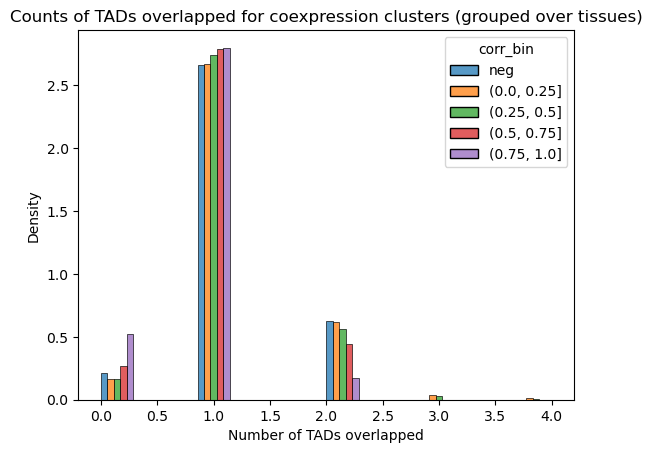

In [249]:
clusters_grouped['corr_bin'] = np.where(~clusters_grouped['Mean_neg_cor'].isna(), 'neg', pd.cut(clusters_grouped['Mean_pos_cor'], [0, .25, .5, .75, 1]))
clusters_grouped['corr_bin'] = clusters_grouped['corr_bin'].astype(str)

clusters_grouped['num_tads_clip'] = clusters_grouped['num_tads'].clip(0,4)

corr_bin_order = ['neg', '(0.0, 0.25]', '(0.25, 0.5]','(0.5, 0.75]', '(0.75, 1.0]']

sns.histplot(clusters_grouped, x='num_tads_clip', hue='corr_bin', stat='density', common_norm=False, multiple='dodge', hue_order=corr_bin_order)
plt.xlabel('Number of TADs overlapped')
plt.title('Counts of TADs overlapped for coexpression clusters (grouped over tissues)')

Text(0, 0.5, 'clusters in 1 TAD/clusters in multiple TADs')

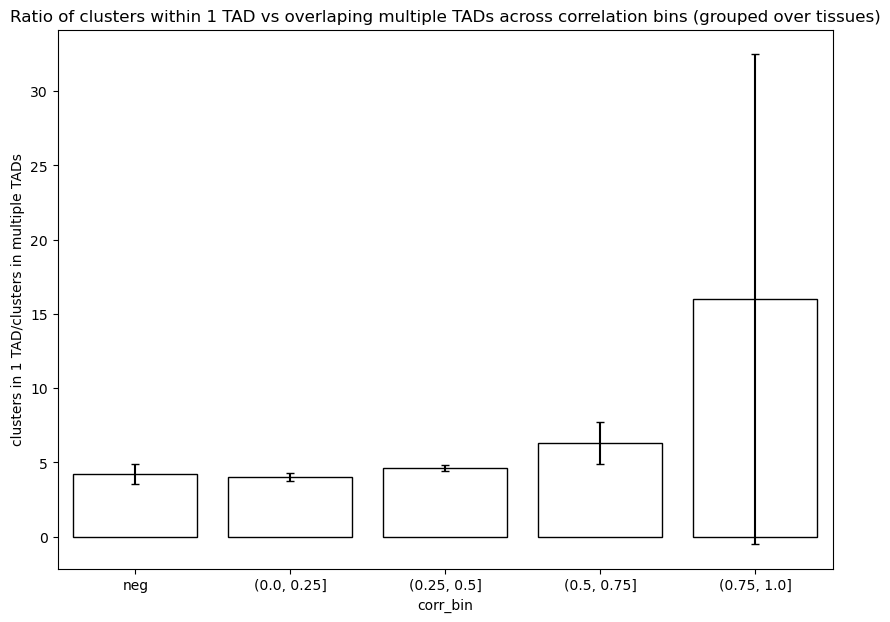

In [276]:
# plot this as a ratio
tads_overlap_count = clusters_grouped[clusters_grouped['num_tads']>1].groupby('corr_bin')['num_tads'].count()
tads_single_count = clusters_grouped[clusters_grouped['num_tads']==1].groupby('corr_bin')['num_tads'].count()
ratios, ratio_errors = calculate_ratio_error(tads_single_count, tads_overlap_count)

fig, ax = plt.subplots(figsize=(10,7))

ax.errorbar(x=corr_bin_order, y=ratios.loc[corr_bin_order], yerr=ratio_errors.loc[corr_bin_order], fmt=' ', color='k', capsize=3)

sns.barplot(ratios, order=corr_bin_order, edgecolor='k', facecolor='white')
plt.title('Ratio of clusters within 1 TAD vs overlaping multiple TADs across correlation bins (grouped over tissues)')
plt.ylabel('clusters in 1 TAD/clusters in multiple TADs')

## multiple cell type TADs 

maybe I will get a TADs lining up with cell types related to that tissue?

In [372]:
# or try with another tad set
tad_path = '/home/klawren/oak/coexp_eqtl/data/TAD_annotations/TADs_hg38/converted_HiC_GM12878_DI_10kb.txt'

tad_df = pd.read_csv(tad_path, header=None, sep='\t', names=['Chromosome', 'start','end'])
tad_df.head()

,Chromosome,start,end
0,chr1,804620,1294620
1,chr1,1324620,1748561
2,chr1,1778561,1918561
3,chr1,1918561,2388561
4,chr1,2388561,2678561


In [373]:
# add in tad size
tad_df['log_size'] = np.log10(tad_df['end'] - tad_df['start'])
tad_df['Tissue'] = 'TAD'

# add tad overlap with clusters
tad_df['inter'] = pd.arrays.IntervalArray.from_arrays(tad_df['start'], tad_df['end'])

def count_tad_overlap(row):
    tad_chr = tad_df[tad_df['Chromosome']==row.Chromosome]
    chr_tad_intervals = pd.arrays.IntervalArray.from_arrays(tad_chr['start'], tad_chr['end'])
    return sum(chr_tad_intervals.overlaps(row['inter']))

<AxesSubplot: xlabel='num_tads', ylabel='Density'>

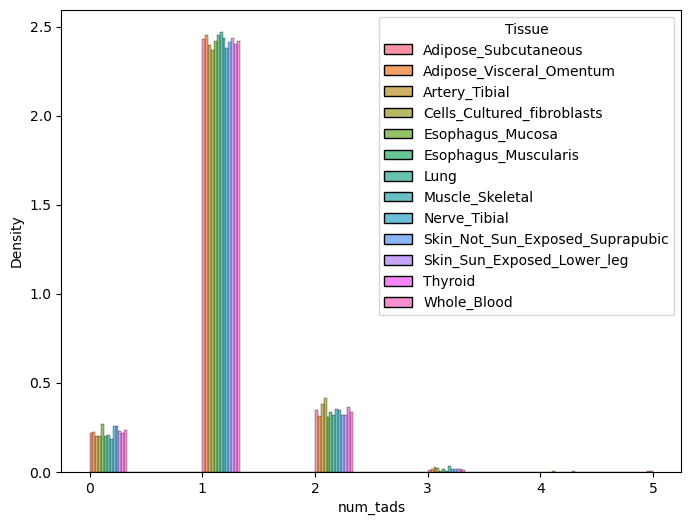

In [374]:
clusters['num_tads'] = clusters.apply(count_tad_overlap, axis=1)
fig, ax = plt.subplots(figsize=(8,6))

sns.histplot(clusters, x='num_tads', hue='Tissue',stat='density', common_norm=False, multiple='dodge', ax=ax)

Text(0.5, 1.0, 'Counts of TADs overlapped for coexpression clusters')

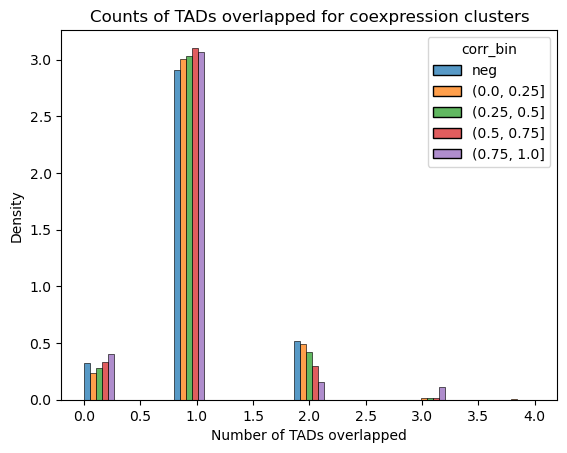

In [375]:
clusters['corr_bin'] = np.where(~clusters['Mean_neg_cor'].isna(), 'neg', pd.cut(clusters['Mean_pos_cor'], [0, .25, .5, .75, 1]))
clusters['corr_bin'] = clusters['corr_bin'].astype(str)

clusters['num_tads_clip'] = clusters['num_tads'].clip(0,4)

corr_bin_order = ['neg', '(0.0, 0.25]', '(0.25, 0.5]','(0.5, 0.75]', '(0.75, 1.0]']

sns.histplot(clusters, x='num_tads_clip', hue='corr_bin', stat='density', common_norm=False, multiple='dodge', hue_order=corr_bin_order)
plt.xlabel('Number of TADs overlapped')
plt.title('Counts of TADs overlapped for coexpression clusters')

Text(0, 0.5, 'clusters in 1 TAD/clusters in multiple TADs')

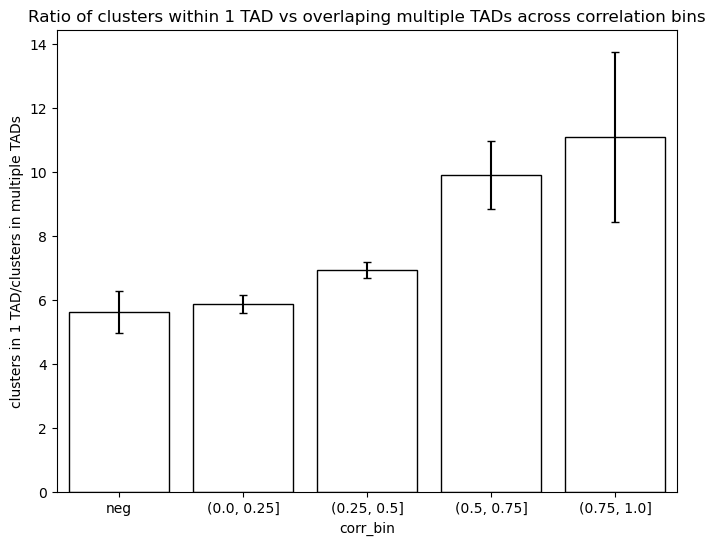

In [376]:
tads_overlap_count = clusters[clusters['num_tads']>1].groupby('corr_bin')['num_tads'].count()
tads_single_count = clusters[clusters['num_tads']==1].groupby('corr_bin')['num_tads'].count()

ratios, ratio_errors = calculate_ratio_error(tads_single_count, tads_overlap_count)

fig, ax = plt.subplots(figsize=(8,6))

ax.errorbar(x=corr_bin_order, y=ratios.loc[corr_bin_order], yerr=ratio_errors.loc[corr_bin_order], fmt=' ', color='k', capsize=3)

sns.barplot(ratios, order=corr_bin_order, edgecolor='k', facecolor='white')
plt.title('Ratio of clusters within 1 TAD vs overlaping multiple TADs across correlation bins')
plt.ylabel('clusters in 1 TAD/clusters in multiple TADs')

Text(0, 0.5, 'clusters in 1 TAD/clusters in multiple TADs')

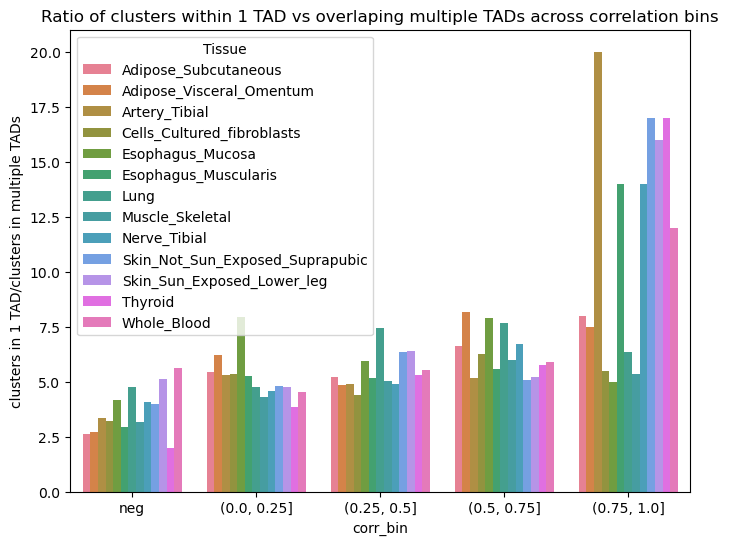

In [301]:
# split up those ratios over tissue type

tads_overlap_count = clusters[clusters['num_tads']>1].groupby(['corr_bin', 'Tissue'])['num_tads'].count()
tads_single_count = clusters[clusters['num_tads']==1].groupby(['corr_bin', 'Tissue'])['num_tads'].count()

ratios, ratio_errors = calculate_ratio_error(tads_single_count, tads_overlap_count)

fig, ax = plt.subplots(figsize=(8,6))

#ax.errorbar(x=corr_bin_order, y=ratios.loc[corr_bin_order], yerr=ratio_errors.loc[corr_bin_order], fmt=' ', color='k', capsize=3)

sns.barplot(pd.DataFrame(ratios), hue='Tissue', x='corr_bin', y='num_tads', order=corr_bin_order)
plt.title('Ratio of clusters within 1 TAD vs overlaping multiple TADs across correlation bins')
plt.ylabel('clusters in 1 TAD/clusters in multiple TADs')

to compare over multiple cell lines and tissue, I need to summarize positive vs negative corr TAD overlap in one number. 

I'll do a heatmap of TAD overlap with tissue on the x and cell line on the y

In [385]:
def count_tad_overlap(row, tad_df):
    tad_chr = tad_df[tad_df['Chromosome']==row.Chromosome]
    chr_tad_intervals = pd.arrays.IntervalArray.from_arrays(tad_chr['start'], tad_chr['end'])
    return sum(chr_tad_intervals.overlaps(row['inter']))

In [399]:
# calculate ratios for a tad set
# takes about 20 secs

def get_tad_ratios(tad_path, cell_type, plot=False):
    tad_df = pd.read_csv(tad_path, header=None, sep='\t', names=['Chromosome', 'start','end'])
    # add size
    tad_df['log_size'] = np.log10(tad_df['end'] - tad_df['start'])
    tad_df['Tissue'] = 'TAD'
    # add tad overlap with clusters
    tad_df['inter'] = pd.arrays.IntervalArray.from_arrays(tad_df['start'], tad_df['end'])
    clusters['num_tads'] = clusters.apply(count_tad_overlap, args=(tad_df,), axis=1)

    if plot:
        # plot out the counts
        clusters['num_tads_clip'] = clusters['num_tads'].clip(0,4)
        fig, ax = plt.subplots(figsize=(8,6))
        sns.histplot(clusters, x='num_tads_clip', hue='corr_bin', stat='density', common_norm=False, multiple='dodge', hue_order=corr_bin_order, ax=ax)
        plt.xlabel('Number of TADs overlapped')
        plt.title('Counts of TADs overlapped for coexpression clusters in {}'.format(cell_type))

        # plot out the ratios
        fig, ax = plt.subplots(figsize=(8,6))
        tads_overlap_count = clusters[clusters['num_tads']>1].groupby('corr_bin')['num_tads'].count()
        tads_single_count = clusters[clusters['num_tads']==1].groupby('corr_bin')['num_tads'].count()
        ratios, ratio_errors = calculate_ratio_error(tads_single_count, tads_overlap_count)
        ax.errorbar(x=corr_bin_order, y=ratios.loc[corr_bin_order], yerr=ratio_errors.loc[corr_bin_order], fmt=' ', color='k', capsize=3)
        sns.barplot(ratios, order=corr_bin_order, edgecolor='k', facecolor='white', ax=ax)
        plt.title('Ratio of clusters within 1 TAD vs overlaping multiple TADs across correlation bins in {}'.format(cell_type))
        plt.ylabel('clusters in 1 TAD/clusters in multiple TADs')

    # get the counts of in different bins, grouped by tissue
    tads_overlap_count = clusters[clusters['num_tads']>1].groupby(['corr_bin', 'Tissue'])['num_tads'].count()
    tads_single_count = clusters[clusters['num_tads']==1].groupby(['corr_bin', 'Tissue'])['num_tads'].count()
    # get ratios of overlapping vs not
    ratios, ratio_errors = calculate_ratio_error(tads_single_count, tads_overlap_count)
    
    return ratios, ratio_errors

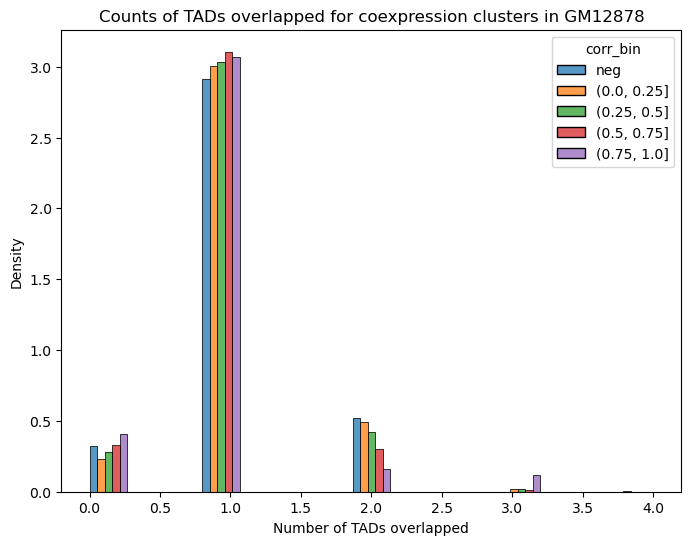

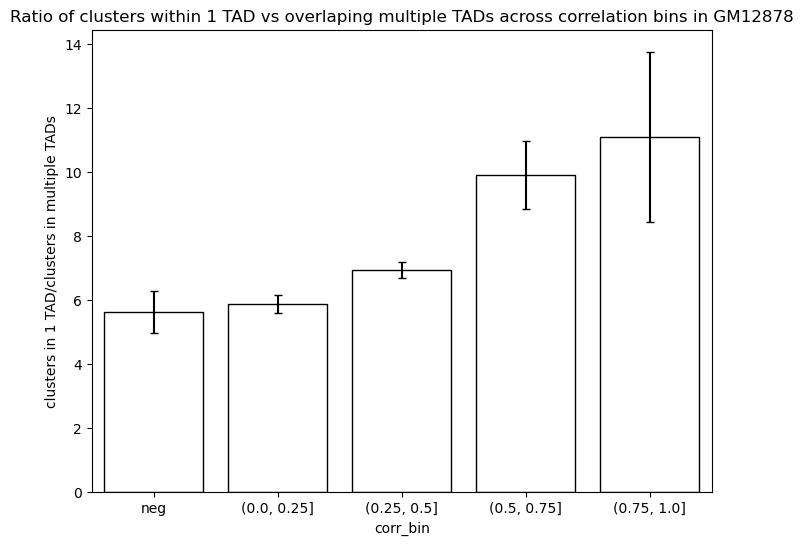

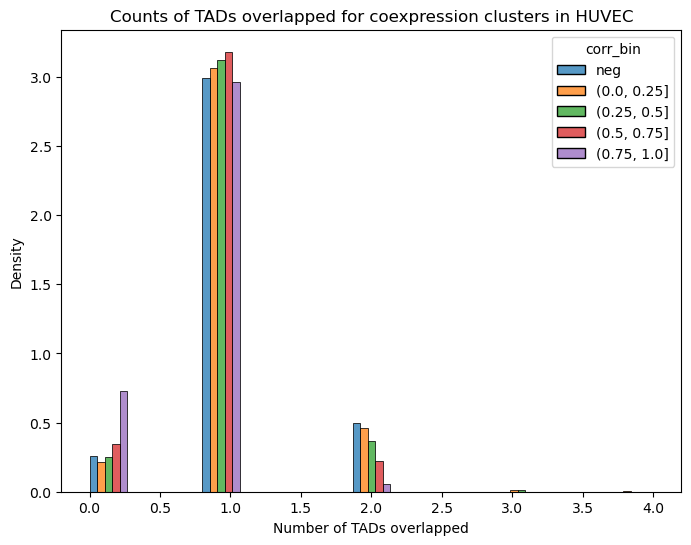

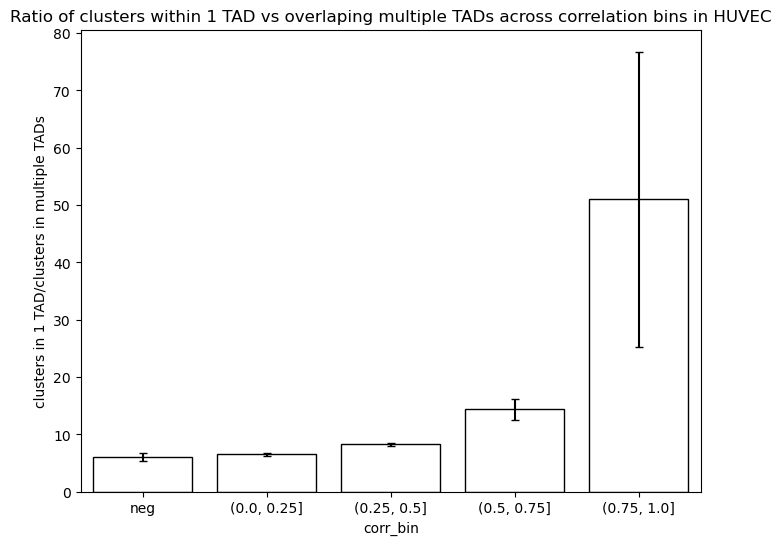

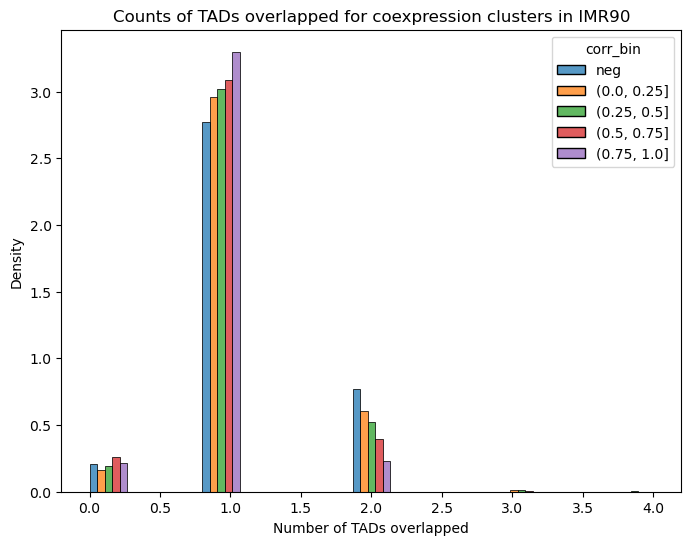

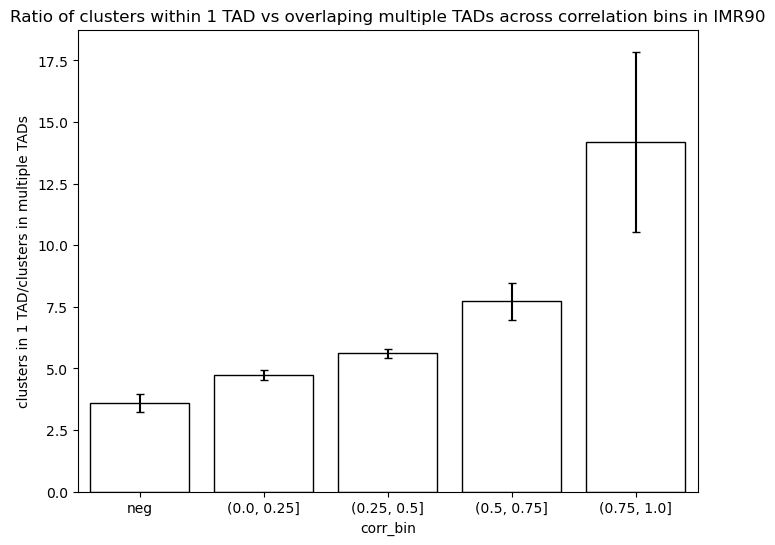

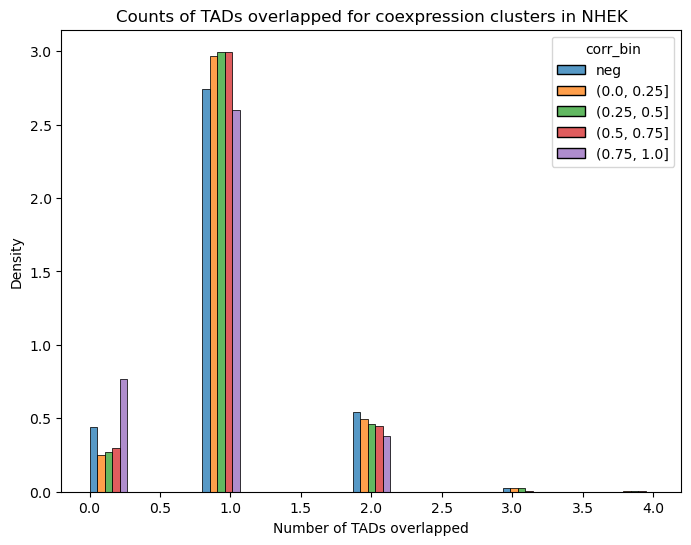

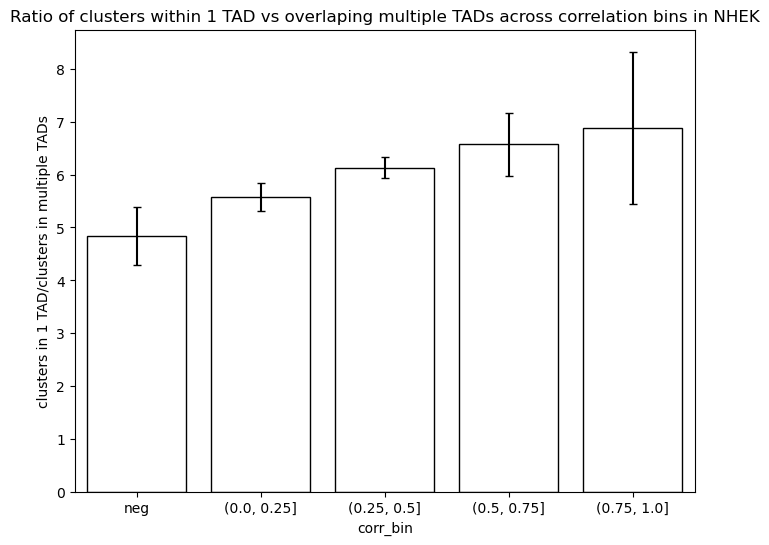

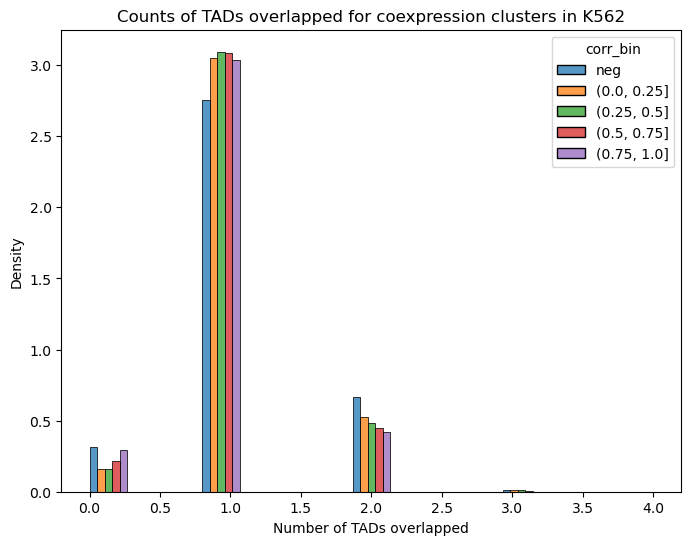

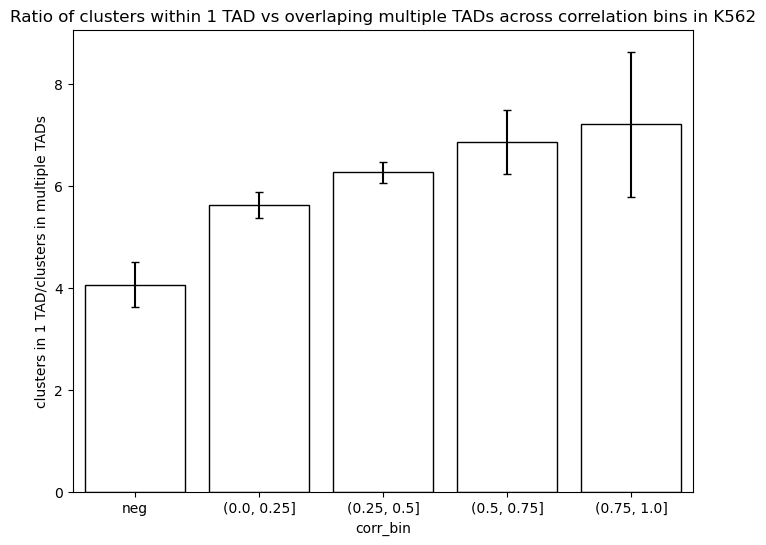

In [404]:
ratios = []
ratio_errors = []

for cell_type in ['GM12878', 'HUVEC', 'IMR90', 'NHEK', 'K562']:
    ratio, ratio_error = get_tad_ratios(f'/home/klawren/oak/coexp_eqtl/data/TAD_annotations/TADs_hg38/converted_HiC_{cell_type}_DI_10kb.txt', cell_type, plot=True)
    ratios.append(ratio)
    ratio_errors.append(ratio_error)

In [445]:
# combine into one df
cell_type_df = pd.DataFrame(pd.concat(ratios, keys=['GM12878', 'HUVEC', 'IMR90', 'NHEK', 'K562'], names=['cell_type', 'corr_bin', 'Tissue']))
cell_type_df = cell_type_df.reset_index()
cell_type_df = cell_type_df.pivot(index=['Tissue', 'cell_type'], columns='corr_bin', values='num_tads')
cell_type_df = cell_type_df[corr_bin_order]

# combine into one df
cell_type_errors_df = pd.DataFrame(pd.concat(ratio_errors, keys=['GM12878', 'HUVEC', 'IMR90', 'NHEK', 'K562'], names=['cell_type', 'corr_bin', 'Tissue']))
cell_type_errors_df = cell_type_errors_df.reset_index()
cell_type_errors_df = cell_type_errors_df.pivot(index=['Tissue', 'cell_type'], columns='corr_bin', values='num_tads')
cell_type_errors_df = cell_type_errors_df[corr_bin_order]


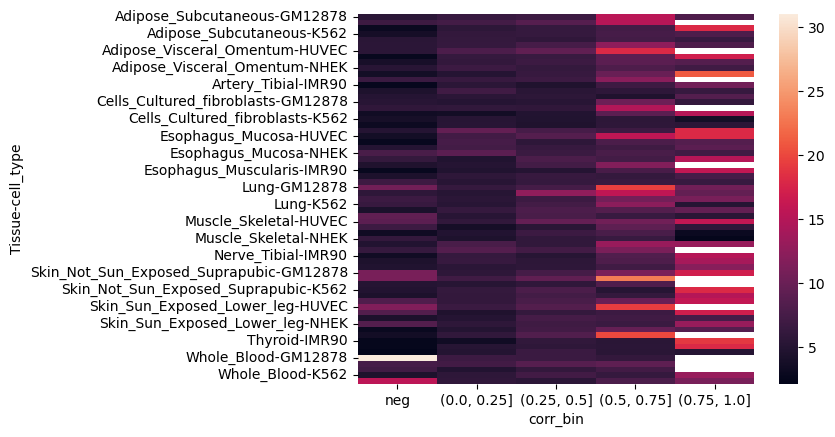

In [442]:
# make a heatmap with tissue-cell type pairs as the rows
sns.heatmap(cell_type_df)
plt.show()

In [446]:
select_cell_type_df = cell_type_df.loc[[('Whole_Blood', 'GM12878'), 
                  ('Cells_Cultured_fibroblasts', 'IMR90'), 
                  ('Skin_Not_Sun_Exposed_Suprapubic', 'NHEK'), 
                  ('Skin_Sun_Exposed_Lower_leg', 'NHEK'), 
                  ('Whole_Blood', 'K562')]]

select_cell_type_errors_df = cell_type_errors_df.loc[[('Whole_Blood', 'GM12878'), 
                  ('Cells_Cultured_fibroblasts', 'IMR90'), 
                  ('Skin_Not_Sun_Exposed_Suprapubic', 'NHEK'), 
                  ('Skin_Sun_Exposed_Lower_leg', 'NHEK'), 
                  ('Whole_Blood', 'K562')]]

In [457]:
annotated = pd.DataFrame(index=select_cell_type_df.index, columns=select_cell_type_df.columns)
# Fill 'annotated' dataframe with values from 'ratios' and 'ratio_errors' in the desired format
for i in select_cell_type_df.index:
    for j in select_cell_type_df.columns:
        annotated.loc[i, j] = f"{select_cell_type_df.loc[i, j]:.1f}±{select_cell_type_errors_df.loc[i, j]:.1f}"

annotated.head()

,corr_bin,neg,"(0.0, 0.25]","(0.25, 0.5]","(0.5, 0.75]","(0.75, 1.0]"
Tissue,cell_type,,,,,
Whole_Blood,GM12878,31.0±31.5,6.7±1.0,6.6±0.9,6.0±2.2,nan±nan
Cells_Cultured_fibroblasts,IMR90,3.4±1.0,3.6±0.6,4.8±0.5,9.0±3.4,15.0±15.5
Skin_Not_Sun_Exposed_Suprapubic,NHEK,4.3±2.0,6.0±1.1,7.3±1.0,6.1±2.1,15.0±15.5
Skin_Sun_Exposed_Lower_leg,NHEK,8.4±4.0,5.7±0.9,6.9±0.9,6.6±2.5,13.0±13.5
Whole_Blood,K562,4.5±2.0,5.7±0.8,7.1±1.0,6.2±2.2,13.0±13.5


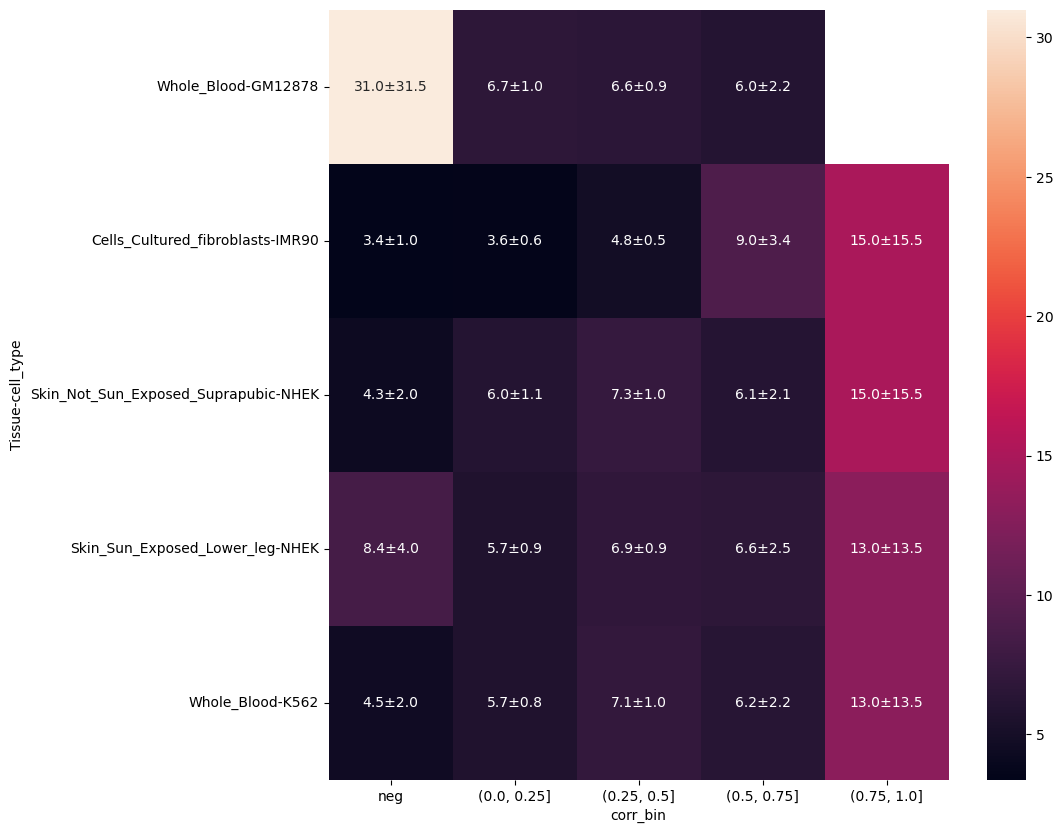

In [459]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(select_cell_type_df, annot=annotated.values,fmt='', ax=ax)
plt.show()